# Sentiment Analysis of Gujarat Election 2017

## 1.Extraction of Tweets

Import the necessary methods from tweepy library.

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
import datetime as dt
import time
import os
import sys

Creation of functions for later use with user credentails.

In [ ]:
def load_api():
    #Variables that contains the user credentials to access Twitter API 
    consumer_key = 'WtmGPZ3A8CGIIT5WyFqlz3MgY'
    consumer_secret = 'yDNWlQUYAyCXUtlV6wLBUhDPHIbIBdO3FWEPqZz6PwhUgIkD1z'
    access_token = '940886757003878400-b6MGtBUqVrZru2VkPLOLFOUNCIEZYtc'
    access_secret = '6RkWSJfYc5KzUo8WX50xtB9C5TMr1yLhuF8S3NpDjoceS'
    auth = OAuthHandler(consumer_key, consumer_secret)   ## create OAuthHandler object
    auth.set_access_token(access_token, access_secret)       
    # load the twitter API via tweepy
    return tweepy.API(auth)

def tweet_search(api, query, max_tweets, max_id, since_id, geocode):
    searched_tweets = []  # create empty dictionary which will contain searched tweets
    while len(searched_tweets) < max_tweets:
        remaining_tweets = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, count=remaining_tweets,
                                    since_id=str(since_id),
                                    max_id=str(max_id-1))
            print('found',len(new_tweets),'tweets')
            if not new_tweets:
                print('no tweets found')
                break
            searched_tweets.extend(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError:
            print('exception raised, waiting 15 minutes')
            print('(until:', dt.datetime.now()+dt.timedelta(minutes=15), ')')
            time.sleep(15*60)
            break # stop the loop
    return searched_tweets, max_id
def get_tweet_id(api, date='', days_ago=6, query='Gujarat Election'):
    if date:
        # return an ID from the start of the given day
        td = date + dt.timedelta(days=1)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        tweet = api.search(q=query, count=1, until=tweet_date)
    else:
        # return an ID from __ days ago
        td = dt.datetime.now() - dt.timedelta(days=days_ago)
        tweet_date = '{0}-{1:0>2}-{2:0>2}'.format(td.year, td.month, td.day)
        # get list of up to 10 tweets
        tweet = api.search(q=query, count=10, until=tweet_date)
        print('search limit (start/stop):',tweet[0].created_at)
        # return the id of the first tweet in the list
        return tweet[0].id
def write_tweets(tweets, filename):
    ''' Function that appends tweets to a file. '''
    with open(filename, 'a') as f:
        for tweet in tweets:
            json.dump(tweet._json, f)
            f.write('\n')

Creation of main function and by using above functions with following inputs:
    
    search_phrases = ['#gujaratelection2017']
    time_limit = 1.5                           
    max_tweets = 100                           
    min_days_old, max_days_old = 0, 7          
    India = ' 21.14,79.088860,3073 km '  

We are generating json files that contains tweets and their respective informations.

In [ ]:
def main():
    ''' This is a script that continuously searches for tweets
        that were created over a given number of days. The search
        dates and search phrase can be changed below. '''

    ''' search variables: '''
    search_phrases = ['#gujaratelection2017']
    time_limit = 1.5                           # runtime limit in hours
    max_tweets = 100                           # number of tweets per search (will be iterated over) : maximum is 100
                                             
    min_days_old, max_days_old = 0, 7          # search limits e.g., from 2 to 7
                                               
    India = '21.14,79.088860,3073 km'          # this geocode includes nearly all India
                                               
    

    # loop over search items,
    # creating a new file for each
    for search_phrase in search_phrases:

        print('Search phrase =', search_phrase)

        ''' other variables '''
        name = search_phrase.split()[0]
        json_file_root = name + '/'  + name
        os.makedirs(os.path.dirname(json_file_root), exist_ok=True)
        read_IDs = False
        
        # open a file in which to store the tweets
        if max_days_old - min_days_old == 1:
            d = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}'.format(d.year, d.month, d.day)
        else:
            d1 = dt.datetime.now() - dt.timedelta(days=max_days_old-1)
            d2 = dt.datetime.now() - dt.timedelta(days=min_days_old)
            day = '{0}-{1:0>2}-{2:0>2}_to_{3}-{4:0>2}-{5:0>2}'.format(
                  d1.year, d1.month, d1.day, d2.year, d2.month, d2.day)
        json_file = json_file_root + '_' + day + '.json'
        if os.path.isfile(json_file):
            print('Appending tweets to file named: ',json_file)
            read_IDs = True
        
        # authorize and load the twitter API
        api = load_api()
        
        # set the 'starting point' ID for tweet collection
        if read_IDs:
            # open the json file and get the latest tweet ID
            with open(json_file, 'r') as f:
                lines = f.readlines()
                max_id = json.loads(lines[-1])['id']
                print('Searching from the bottom ID in file')
        else:
            # get the ID of a tweet that is min_days_old
            if min_days_old == 0:
                max_id = -1
            else:
                max_id = get_tweet_id(api, days_ago=(min_days_old-1))
        # set the smallest ID to search for
        since_id = get_tweet_id(api, days_ago=(max_days_old-1))
        print('max id (starting point) =', max_id)
        print('since id (ending point) =', since_id)
        


        ''' tweet gathering loop  '''
        start = dt.datetime.now()
        end = start + dt.timedelta(hours=time_limit)
        count, exitcount = 0, 0
        while dt.datetime.now() < end:
            count += 1
            print('count =',count)
            # collect tweets and update max_id
            tweets, max_id = tweet_search(api, search_phrase, max_tweets,
                                          max_id=max_id, since_id=since_id,
                                          geocode=India)
            # write tweets to file in JSON format
            if tweets:
                write_tweets(tweets, json_file)
                exitcount = 0
            else:
                exitcount += 1
                if exitcount == 3:
                    if search_phrase == search_phrases[-1]:
                        sys.exit('Maximum number of empty tweet strings reached - exiting')
                    else:
                        print('Maximum number of empty tweet strings reached - breaking')
                        break


if __name__ == "__main__":
    main() 

The above code has ran for around 10 minutes and the json file with name gujaratelection2017 is created.

## 2. Creation of Bag  of  words
#NumPy: This is the fundamental package for scientific computing with Python. Besides its obvious scientific uses, NumPy can also be used as an efficient multi-dimensional container of generic data.

#Pandas: This is an open source library providing high-performance, easy-to-use data structures and data analysis tools.

#Matplotlib: This is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# df = pd.read_json('GujaratElection.json',lines=True)

In [35]:
df.head()

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,NaN,2017-12-15 13:28:47,"{'hashtags': [{'indices': [42, 62], 'text': 'G...","{'media': [{'indices': [98, 121], 'source_user...",0,False,NaN,941661315973627906,941661315973627904,...,NaN,NaN,NaN,3,False,"{'is_quote_status': False, 'contributors': Non...","<a href=""http://twitter.com/download/iphone"" r...","RT @hiralddave: So, its 68.41% voting for #Guj...",False,"{'is_translator': False, 'name': 'Akshaya Muku..."
1,NaN,NaN,2017-12-15 13:28:42,"{'hashtags': [{'indices': [46, 55], 'text': 's...",NaN,0,False,NaN,941661293726932992,941661293726932992,...,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...",Ab pachtaye kya hot jab chidiya chug gyi khet\...,False,"{'is_translator': False, 'name': 'BrJi™ #MKJi'..."
2,NaN,NaN,2017-12-15 13:28:36,"{'hashtags': [{'indices': [39, 48], 'text': 'E...",NaN,0,False,NaN,941661267873460224,941661267873460224,...,NaN,NaN,NaN,32,False,"{'is_quote_status': False, 'contributors': Non...","<a href=""http://twitter.com/download/android"" ...",RT @Being_reena: दिल्ली के मालिक सारे #ExitPo...,False,"{'is_translator': False, 'name': 'ARMY HIND🇮🇳L..."
3,NaN,NaN,2017-12-15 13:28:34,"{'hashtags': [{'indices': [48, 68], 'text': 'G...",NaN,0,False,NaN,941661262844272640,941661262844272640,...,NaN,NaN,NaN,4,False,"{'is_quote_status': False, 'contributors': Non...","<a href=""http://twitter.com/download/android"" ...",RT @NewsWorldIN: BJP will meet the same fate i...,False,"{'is_translator': False, 'name': 'Rajiv Sinha'..."
4,NaN,NaN,2017-12-15 13:28:27,"{'hashtags': [{'indices': [48, 68], 'text': 'G...",NaN,0,False,NaN,941661229801644032,941661229801644032,...,NaN,NaN,NaN,4,False,"{'is_quote_status': False, 'contributors': Non...","<a href=""http://twitter.com/download/android"" ...",RT @NewsWorldIN: BJP will meet the same fate i...,False,"{'is_translator': False, 'name': 'Bharat Solan..."


#### I decided to only do sentiment analysis on this dataset, therfore I dropped the unnecessary colunns, keeping only sentiment and text

In [24]:
df1=df[['id','text']] 
df1.head()

,id,text
0,941661315973627906,"RT @hiralddave: So, its 68.41% voting for #Guj..."
1,941661293726932992,Ab pachtaye kya hot jab chidiya chug gyi khet\...
2,941661267873460224,RT @Being_reena: दिल्ली के मालिक सारे #ExitPo...
3,941661262844272640,RT @NewsWorldIN: BJP will meet the same fate i...
4,941661229801644032,RT @NewsWorldIN: BJP will meet the same fate i...


In [25]:
text1=df1.text.str.split(" ") #Here we split the text into words with space

## Translation Hindi tweets into English tweets

In [26]:
!pip install goslate 

In [28]:
# import goslate
# New_text = []
# for index, row in df1.iterrows():
#         gs=goslate.Goslate()
#         translatedText=gs.translate(row[1],'en')
#         New_text.append(translatedText)

In [29]:
# df1['New_text']=np.array(New_text)
# df1.head()

Finally, we need to decide how to deal with frequently occurring words that don't carry much meaning. Such words are called "stop words"; in English they include words such as "a", "and", "is", and "the". Conveniently, there are Python packages that come with stop word lists built in. Let's import a stop word list from the Python Natural Language Toolkit (NLTK). You'll need to install the library if you don't already have it on your computer; you'll also need to install the data packages that come with it, as follows:

In [30]:
!pip install BeautifulSoup4
!pip install nltk

# Data Cleaning and Text Preprocessing
#Removing HTML Markup: The BeautifulSoup Package
First, we'll remove the HTML tags. For this purpose, we'll use the Beautiful Soup library.

#To remove punctuation and numbers, we will use a package for dealing with regular expressions, called re. The package comes built-in with Python; no need to install anything.

In [ ]:
from bs4 import BeautifulSoup 
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
def preprocessing( raw_tweet ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    tweet_text = BeautifulSoup(raw_tweet, "lxml").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", tweet_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [ ]:
Processed_New_text=[]
for i in range(0,len(df3)):
    Processed_New_text.append(preprocessing( df3.New_text[i]))

In [ ]:
df1['Processed_New_text']=np.array(Processed_New_text)

In [ ]:
df1.to_csv('processed_Gujarat_text.csv') # Conversion of DataFrame to CSV file

## 3. Sentiment Analysis

In [3]:
df2 = pd.read_csv('processed_Gujarat_text.csv') # Here we Read CSV file which we have from above code
df2 = df2[['id','New_New_text']]
df2.head()

In [86]:
df2.rename(columns={'New_New_text':"text"}, inplace=True) # Here we Rename the column name 
df2.head()

,id,text
0,941661315973627906,rt hiralddave voting gujaratelection httweets ...
1,941661293726932992,ab pachtaye kya hot jab chidiya chug gyi khet ...
2,941661267873460224,rt reena making government majority gujarat ha...
3,941661262844272640,rt newsworldin bjp meet fate gujaratelection m...
4,941661229801644032,rt newsworldin bjp meet fate gujaratelection m...


### Importing textblob
This is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks.

Textblob will allow us to do sentiment analysis in a very simple way.For this,  
a) create a classifier to analyze the polarity of each tweet after cleaning the text in it. 

In [87]:
from textblob import TextBlob

def analize_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [88]:
#  We create a column with the result of the analysis:
df_sentiment=np.array([ analize_sentiment(words) for words in (df1['text'])])

In [90]:
df2['Sentiment']=pd.Series(df_sentiment)

In [92]:
df2.head()

,id,text,Sentiment
0,941661315973627906,rt hiralddave voting gujaratelection httweets ...,0
1,941661293726932992,ab pachtaye kya hot jab chidiya chug gyi khet ...,-1
2,941661267873460224,rt reena making government majority gujarat ha...,0
3,941661262844272640,rt newsworldin bjp meet fate gujaratelection m...,1
4,941661229801644032,rt newsworldin bjp meet fate gujaratelection m...,1


In [93]:
df2['Sentiment'].value_counts()
percent=(df2['Sentiment'].value_counts())/(len(df2['Sentiment']))*100
percent

 0    72.8
 1    24.8
-1     2.4
Name: Sentiment, dtype: float64

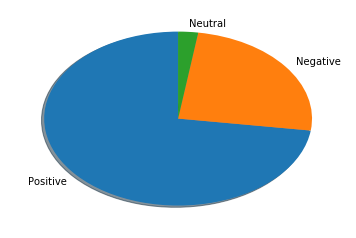

In [94]:
value=percent.values
labels='Positive','Negative','Neutral'
plt.pie(value,labels=labels,shadow=True,startangle = 90)
plt.show()